# Complex source+lens reconstruction using _starlets_
This notebooks aims to be a first tentative to express light on pixelated grid, and building the mapping between source and image planes, for an implementation in _lenstronomy_.

In [1]:
__author__ = 'aymgal'
import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import pysap
import pickle as pkl

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import kernel_util

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Util.util import dirac_impulse
from slitronomy.Util.plot_util import nice_colorbar, log_cmap

%matplotlib inline

subgrid_res_source = 2

np.random.seed(18)

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

## Generate a mock lens

In [3]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.05  # background noise per pixel
#exp_time = 0  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 41

(41, 41) (82, 82)


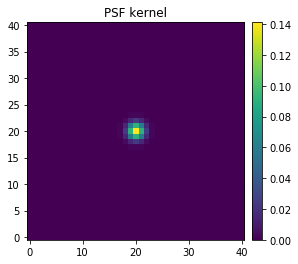

In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    #'exposure_time': np.ones((num_pix, num_pix)) * exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

# PSF specification
no_convolution = False
if no_convolution:
    kwargs_psf = {'psf_type': 'NONE'}
else:
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    psf_kernel_hd = kernel_util.kernel_gaussian(int(psf_num_pix*subgrid_res_source), 
                                                  delta_pix/subgrid_res_source, 
                                                  psf_fwhm)
    print(psf_kernel.shape, psf_kernel_hd.shape)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
    #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm, 'pixel_size': delta_pix, 'truncation': 11}
psf_class = PSF(**kwargs_psf)

plt.title("PSF kernel")
im = plt.imshow(psf_class.kernel_point_source, origin='lower')
nice_colorbar(im)
plt.show()

In [5]:
lens_model_list = ['SPEMD']
kwargs_spemd = {'theta_E': 2.2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
# get an pre-processed source galaxy from galsim
galsim_index = 1
snr = 500
galsim_data_path = ('data/ring_sims/sims_SNR{}/simring_galsim{}_all.pkl'.format(snr, galsim_index))
[data, truth, lens_model] = pkl.load(open(galsim_data_path, 'rb'))
galsim_num_pix = data['num_pix']
galsim_delta_pix = data['delta_pix']
galsim_delta_pix /= 3  # because we are using high res x 3 galsim below
galsim_source_highres = truth['source_galsim_3']
source_model_list = ['INTERPOL']
kwargs_interpol_source = {'image': galsim_source_highres, 'amp': 2000, 'center_x': +0.3, 'center_y': -0.1, 'phi_G': 0, 
                          'scale': galsim_delta_pix}
kwargs_source = [kwargs_interpol_source]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
#lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
#kwargs_lens_light = [
#    {'amp': 50, 'R_sersic': 1, 'n_sersic': 1, 'e1': kwargs_spemd['e1'], 'e2': kwargs_spemd['e2'],
#     'center_x': kwargs_spemd['center_x']-0.1, 'center_y': kwargs_spemd['center_y']-0.1},
#    {'amp': 3, 'R_sersic': 2, 'n_sersic': 4, 'e1': kwargs_spemd['e1'], 'e2': kwargs_spemd['e2'],
#     'center_x': kwargs_spemd['center_x']+0.1, 'center_y': kwargs_spemd['center_y']+0.1}
#]
lrg_data_path = ('../dev_notebooks/sample_LRGs/cutout_LRG.fits')
with pf.open(lrg_data_path) as f:
    lrg_light = f[0].data
lens_light_model_list = ['INTERPOL']
factor = 1
kwargs_interpol_lens = {'image': lrg_light, 'amp': 1000, 'center_x': 0, 'center_y': 0, 'phi_G': 0, 
                        'scale': 0.08}
kwargs_lens_light = [kwargs_interpol_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

In [6]:
kwargs_numerics = {'supersampling_factor': 2, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, 
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
#data_class.update_data(image_sim)
data_class = ImageData(**kwargs_data)

In [7]:
# get the light distribution in source plane
source_sim = imageModel.source_surface_brightness(kwargs_source, unconvolved=True, de_lensed=True)
source_sim_1d = lenstro_util.image2array(source_sim)

# get the lens light in image, convolved
lens_light_sim_conv = imageModel.lens_surface_brightness(kwargs_lens_light, unconvolved=False)


## Visualize the imaging data

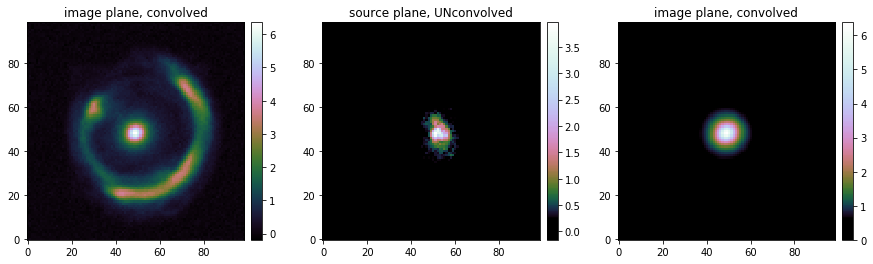

In [8]:
fig = plt.figure(figsize=(15, 4))

ax = plt.subplot2grid((1, 3), (0, 0), fig=fig)
ax.set_title("image plane, convolved")
im = ax.imshow(lin_scale(image_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 1))
ax.set_title("source plane, UNconvolved")
im = ax.imshow(lin_scale(source_sim), origin='lower', cmap=log_cmap('cubehelix', 1e-1, 1))
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 2))
ax.set_title("image plane, convolved")
im = ax.imshow(lin_scale(lens_light_sim_conv), origin='lower', cmap=log_cmap('cubehelix', 1e-1, 1))
nice_colorbar(im)

plt.show()

## Sparse optimizazion to reconstruct the source light

In [9]:
source_model_list_sparsefit = ['STARLETS']
kwargs_starlets_source = {'n_scales': 10, 'n_pixels': np.size(image_sim)*subgrid_res_source**2}
kwargs_source_sparsefit = [kwargs_starlets_source]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

lens_light_model_list_sparsefit = ['STARLETS']
kwargs_starlets_lens_light = {'n_scales': 8, 'n_pixels': np.size(image_sim)}
kwargs_lens_light_sparsefit = [kwargs_starlets_lens_light]
lens_light_model_class_sparsefit = LightModel(light_model_list=lens_light_model_list_sparsefit)


init_lens_light_model = lens_light_sim_conv.copy()


likelihood_mask = None

kwargs_sparse_solver = {
    'source_interpolation': 'bilinear',
    
    'subgrid_res_source': subgrid_res_source,
    'minimal_source_plane': False,
    'min_num_pix_source': 80,
    
    'formulation': 'synthesis',
    'min_threshold': 3,
    'threshold_increment_high_freq': 1,
    'threshold_decrease_type': 'linear',
    'num_iter_source': 20,
    'num_iter_lens': 20,
    'num_iter_weights': 3,
    'verbose': False,
    'show_steps': False,
    'thread_count': 8,
}

imageSparseFit = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                lens_light_model_class=lens_light_model_class_sparsefit,
                                likelihood_mask=likelihood_mask,
                                kwargs_sparse_solver=kwargs_sparse_solver)

In [10]:
print("Running solver...")
start_time = time.time()
model, model_error, param = imageSparseFit.image_sparse_solve(kwargs_lens, kwargs_source=kwargs_source_sparsefit,
                                                              kwargs_lens_light=kwargs_lens_light_sparsefit,
                                                              init_lens_light_model=init_lens_light_model)
end_time = time.time()
print("Runtime : {:.3f} s".format(end_time-start_time))


Running solver...
Runtime : 37.390 s


## Plot results

Negative source pixels ? False (min = 0.00e+00)


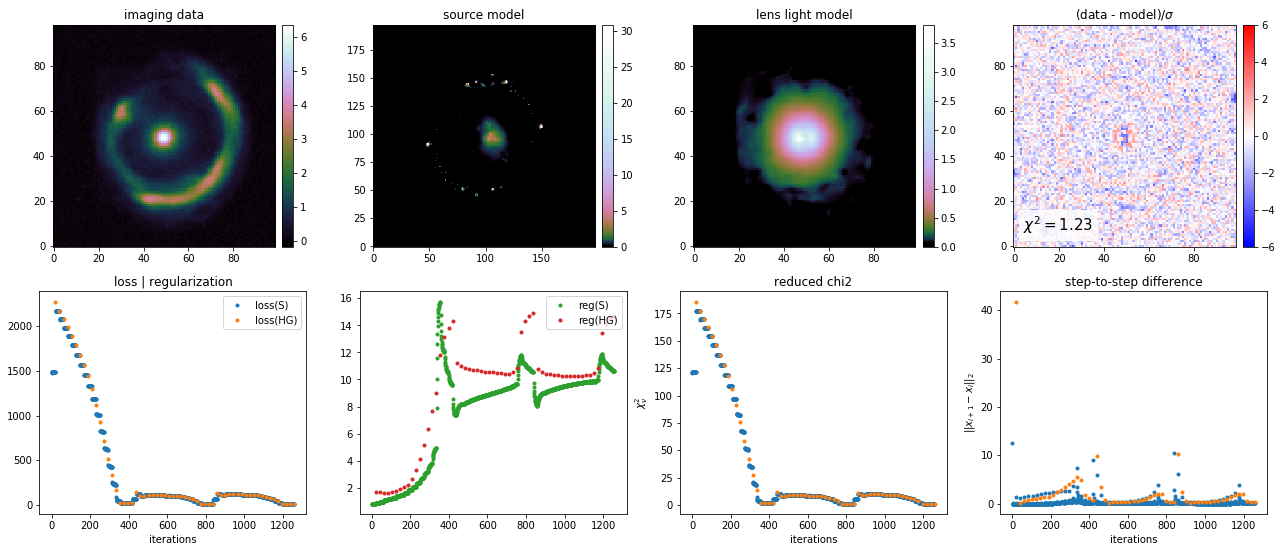

In [11]:
sparseSolver = imageSparseFit.sparseSolver
#lensingOperator = imageSparseFit.lensingOperator

#print(sparseSolver.noise_levels_image_plane.shape)
#for n in range(len(sparseSolver.noise_levels_image_plane)):
#    plt.figure()
#    plt.imshow(sparseSolver.noise_levels_image_plane[n], origin='lower')
#    plt.colorbar()
#    plt.show()

fig = sparseSolver.plot_results(res_vmin=-6, res_vmax=6,
                                cmap_1=log_cmap('cubehelix', 1e-2, 1),
                                cmap_2=log_cmap('cubehelix', 2e-2, 1))
plt.show()

## Plot residuals

In [12]:
print("Updated source kwargs :", kwargs_source_sparsefit)
print("Updated source kwargs :", kwargs_lens_light_sparsefit)

Updated source kwargs : [{'n_scales': 10, 'n_pixels': 39204, 'scale': 0.039999999999999994, 'center_x': 0, 'center_y': 0, 'amp': array([0.        , 0.        , 0.        , ..., 0.01537554, 0.01536096,
       0.01534616])}]
Updated source kwargs : [{'n_scales': 8, 'n_pixels': 9801, 'scale': 0.07999999999999999, 'center_x': 0, 'center_y': 0, 'amp': array([ 0.00000000e+00, -7.33728957e-05, -4.19569144e-04, ...,
        5.03918752e-02,  5.01258634e-02,  4.98527512e-02])}]


In [13]:
# get source reconstructions
source_estimate = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=None, 
                                                           unconvolved=True, de_lensed=True)

# get lens light reconstruction
lens_estimate = imageSparseFit.lens_surface_brightness(kwargs_lens_light_sparsefit, unconvolved=False)

ra_grid_hd, dec_grid_hd = lenstro_util.make_grid(numPix=num_pix, deltapix=delta_pix,
                                                 subgrid_res=subgrid_res_source)
#ra_grid_hd, dec_grid_hd = sparseSolver.lensingOperator.sourcePlane.grid()
source_estimate_hd = source_model_class_sparsefit.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source_sparsefit)
source_estimate_hd = lenstro_util.array2image(source_estimate_hd)

# get the true light distribution in source plane on high res grid
source_sim_hd = source_model_class.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source)
source_sim_hd = lenstro_util.array2image(source_sim_hd)
source_sim_hd *= (delta_pix/subgrid_res_source)**2  # unit conversion
source_sim_hd *= subgrid_res_source**2  # pixeal area ratio

model_unconvolved = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=kwargs_lens,
                                                             unconvolved=True, de_lensed=False,
                                                             update_lens_mapping=False)

TypeError: source_surface_brightness() got an unexpected keyword argument 'update_lens_mapping'

In [ ]:
residuals_source = source_sim - source_estimate
residuals_source_hd = source_sim_hd - source_estimate_hd
residuals_lens = lens_light_sim_conv - lens_estimate


fig, axes = plt.subplots(2, 3, figsize=(15, 10))

ax = axes[0, 0]
ax.set_title("reconstructed source (unconvolved)")
im = ax.imshow(source_estimate_hd, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
ax.set_xlim(len(source_estimate_hd)/4, 3*len(source_estimate_hd)/4)
ax.set_ylim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
nice_colorbar(im)
ax = axes[0, 1]
#ax.set_title("reconstructed source (resized, convolved)")
#im = ax.imshow(source_estimate_conv, origin='lower', cmap='gist_stern')
ax.set_title("true source (unconvolved)")
im = ax.imshow(source_sim_hd, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
ax.set_xlim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
ax.set_ylim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
nice_colorbar(im)
ax = axes[0, 2]
ax.set_title("truth - model (unconvolved)")
im = ax.imshow(residuals_source_hd, origin='lower', cmap='bwr', vmin=-1, vmax=1)
ax.set_xlim(len(residuals_source_hd)/4, 3*len(residuals_source_hd)/4)
ax.set_ylim(len(residuals_source_hd)/4, 3*len(residuals_source_hd)/4)
nice_colorbar(im)

ax = axes[1, 0]
ax.set_title("reconstructed lens (convolved)")
im = ax.imshow(lens_estimate, origin='lower', cmap='cubehelix')
nice_colorbar(im)
ax = axes[1, 1]
#ax.set_title("reconstructed source (resized, convolved)")
#im = ax.imshow(source_estimate_conv, origin='lower', cmap='gist_stern')
ax.set_title("true lens (convolved)")
im = ax.imshow(lens_light_sim_conv, origin='lower', cmap='cubehelix')
nice_colorbar(im)
ax = axes[1, 2]
ax.set_title("truth - model (convolved)")
im = ax.imshow(residuals_lens, origin='lower', cmap='bwr', vmin=-0.6, vmax=0.6)
nice_colorbar(im)

plt.show()